# Modelling Wind Speed and Direction Distribution using Gaussain Mixture Modles (OEN method)

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Modles, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *

## 1.2 Read Data

In [2]:
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # weird shape at 3, try 4
# ipath= './data/NCDC/tiree.txt'
ipath= "./data/NCDC/marham.txt"

# ipath= "./data/NCDC/cheongju_intl/dat.txt"
# ipath= "./data/NCDC/daegu_ab/dat.txt" # recent 5 year data is corrupted

# ipath= "./data/NCDC/canada/st_johns_intl/dat.txt" # lack 2011-12
# ipath= "./data/NCDC/canada/gander_intl/dat.txt" # try 4, lack of 2011-12
# ipath= "./data/NCDC/canada/hay_rivier_a/dat.txt"
# ipath= "./data/NCDC/canada/melita_man/dat.txt" 
# ipath= "./data/NCDC/canada/manouane_est_que/dat.txt" 
# ipath= "./data/NCDC/canada/longue_pointe/dat.txt" 
# ipath= "./data/NCDC/canada/fort_smith/dat.txt"  # lacks inital speed
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt"  # uptail wind speed 
# ipath= "./data/NCDC/canada/lac_benoit_que/dat.txt" # 似乎有速度为0的数据
# ipath= "./data/NCDC/canada/havre_st_pierre/dat.txt" # irregular sample time -> too small dataset
# ipath= "./data/NCDC/canada/moosonee_awos/dat.txt" # irregular sample time -> too small dataset
# ipath= "./data/NCDC/canada/tukialik_bay/dat.txt" # truncate, time shift
# ipath= "./data/NCDC/canada/blank_sablon/dat.txt" # truncate
# ipath= "./data/NCDC/canada/argentia/dat.txt" # weird shape
# ipath= "./data/NCDC/canada/longue_pointe/dat.txt" # data may have problem

# ipath= './data/NCDC/europe/ciampino/dat.txt' # Italy
# ipath= "./data/NCDC/europe/laupheim/dat.txt"
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt"
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak, try 4
# ipath= "./data/NCDC/europe/avord/dat.txt" # double peak. try square error, 4, very good
# ipath= "./data/NCDC/europe/salamanca/dat.txt" # recent 5 year is truncate data, before is better
# ipath= "./data/NCDC/europe/barayas/dat.txt" # try 4, still bad fit
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer

# ipath= "./data/NCDC/dr_ambedkar_intl/dat.txt" # India, not very good

# ipath= "./data/NCDC/south_america/senador_petronio/dat.txt" # unable to chi square
# ipath= "./data/NCDC/south_america/ambrosio_lv/dat.txt" # sectors are 16

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" 
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" # bad fit
# ipath= "./data/NCDC/oceania/auckland/dat.txt"  # Weird KDE shape

# ipath= "./data/NCDC/cn/南京lukou/dat.txt" # good
# ipath= "./data/NCDC/cn/luogang/dat.txt"  # good, try 4
# ipath= "./data/NCDC/cn/binhai/dat.txt" # good, but recent 5 year data may have been corrupted, 05-09 is good
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" # 
# ipath= "./data/NCDC/cn/武汉tianhe/dat.txt" # 
# ipath= "./data/NCDC/cn/wusu/dat.txt" # not quite good, try 4?
# ipath= "./data/NCDC/cn/gushi/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/yueyang/dat.txt" # 16 sectors, some direction deviate big
# ipath= "./data/NCDC/cn/wuxu/dat.txt" # unable to fit with chi square
# ipath= "./data/NCDC/cn/广州baiyun/dat.txt" # Is this dataset correct?
# ipath= "./data/NCDC/cn/zhengding/dat.txt" #  Initial data is weird

# ipath= "./data/NCDC/cn/baoan_intl/dat.txt" # good, but 1个方向的数据过少，很难拟合
# ipath= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" # good
# ipath= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# ipath= './data/NCDC/cn/macau/dat.txt' # not good, feels like truncate data, try 4
# ipath= "./data/NCDC/cn/hk_intl/dat.txt" # truncate dataset

## US dataset, is mostly over a threshold, low wind speed is not complete
# ipath= "./data/NCDC/us/sheboygan/dat.txt" # untruncate us dataset, but recent 5 year maybe corrupted
# ipath= "./data/NCDC/us/sacramento_arp/dat.txt"  
# ipath= "./data/NCDC/us/st_louis_arp/9511346969491dat.txt"  
# ipath= './data/NCDC/us/huron/3461896967321dat.txt'
# ipath= "./data/NCDC/us/baltimore/9963956959409dat.txt"
# ipath= './data/NCDC/us/kennedy/5807936958436dat.txt'
# ipath= './data/NCDC/us/newark/8455636958433dat.txt'
# ipath= './data/NCDC/us/la_guardia/1057036958434dat.txt'
# ipath= "./data/NCDC/us/olympia_airport/2647036962786dat.txt" 
# ipath= "./data/NCDC/us/sidney/6062326959357dat.txt" 
# ipath= "./data/NCDC/us/general_mitchell_intl/dat.txt"
# ipath= "./data/NCDC/us/quad_city_arp/dat.txt" 

## Problem dataset
# ipath= "./data/NCDC/canada/stony_rapids_arpt/dat.txt" # truncate data
# ipath= "./data/NCDC/canada/baker_lake/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/rankin_inlet/dat.txt" # wrong data
# ipath= "./data/NCDC/canada/deer_lake_a/dat.txt" # bad dataset
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # recent year speed wired
# ipath= "./data/NCDC/south_america/carlos_ibanez/dat.txt" # bad dataset, direction
# ipath= "./data/NCDC/south_america/rio_cuarto/dat.txt"  # bad dataset
# ipath= "./data/NCDC/south_america/senador_nilo/dat.txt" # bad dataset, direction 
# ipath= "./data/NCDC/cn/长沙huanghua/dat.txt" # direction may not be real

uipath = unicode(ipath , "utf8")

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed' ]]
else:
    df = read_cn_database(uipath)

In [3]:
df = df.query("(dir < 999) & (speed < 999) & \
              (date >= 19800000) & (date < 20160000) ")
df.index= df['date']

In [4]:
# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360) 
df['dir_windrose'] = df['dir']
# Convert windrose coordianates to Polar Cooridinates 
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)
df.describe()

,date,HrMn,dir,speed,dir_windrose
count,450837.000000,450837.000000,450837.000000,450837.000000,450837.000000
mean,19999219.243984,1168.277794,190.979658,4.741327,184.894217
std,101383.666434,687.409454,93.488902,2.700172,93.930931
min,19800101.000000,0.000000,0.000000,0.500000,0.000000
25%,19910714.000000,600.000000,120.000000,2.600000,120.000000
50%,20020205.000000,1200.000000,210.000000,4.100000,200.000000
75%,20090314.000000,1750.000000,260.000000,6.200000,250.000000
max,20150801.000000,2355.000000,350.000000,28.000000,350.000000


True


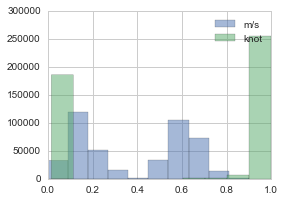

In [5]:
# Detect data stored in knot or m/s
## For data stored originally in knot, the data would cluster at 0.1 and 0.9
df['decimal'] = df.speed % 1 
df.decimal.hist(alpha=0.5, label='m/s', figsize=(4,3))
knot_unit = True if len(df.query('decimal >= 0.2'))/len(df) > 0.3 else False

# Using unit in knot instead of m/s
if knot_unit:
    df['speed']=df['speed']*1.943845
    df['decimal'] = df.speed % 1 
    df.decimal.hist(alpha=0.5,label='knot')
    # need more elaboration, some is not near an integer
    df['speed']=df['speed'].apply(lambda x: int(round(x)))
    plt.legend()

print knot_unit

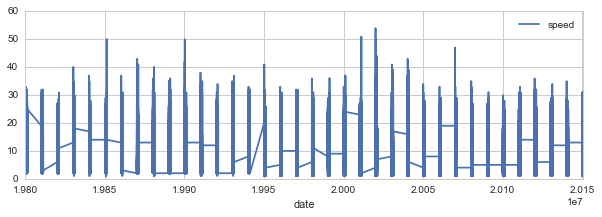

In [6]:
df['speed'].plot(legend=True,figsize=(10,3), grid=True)

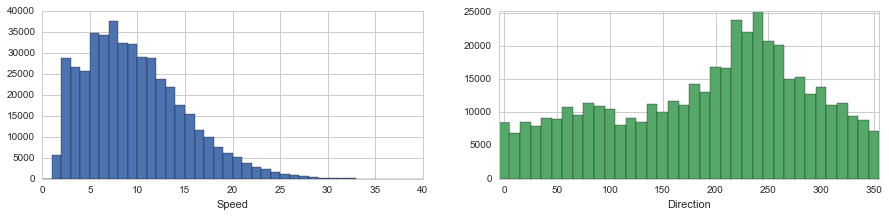

In [7]:
# Notice the gap of the distributions, so futher process needed, as below
plot_speed_and_angle_distribution(df.speed, df.dir)

## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

#### 1.3.1.1 wrong direction record

In [8]:
display(df.query('dir % 10 >= 0.1'))
df = df.query('dir % 10 <= 0.1')

,date,HrMn,type,dir,speed,dir_windrose,decimal
date,,,,,,,
19920706,19920706,1550,FM-15,248,13,202,0.829377
19920919,19920919,850,FM-15,171,2,279,0.943845
19930516,19930516,750,FM-15,331,17,119,0.911451
20020711,20020711,1450,99999,306,3,144,0.304537


#### 1.3.1.2 sudden increase in speed

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
20020128,20020128,1700,FM-12,210,54,240,0.427660,26,27
20011228,20011228,1400,FM-12,170,51,280,0.539970,25,30
19851113,19851113,900,FM-12,230,50,220,0.956817,40,45
19900223,19900223,1000,SY-MT,160,50,290,0.956817,43,45
20020304,20020304,50,FM-15,50,50,40,0.956817,44,46
20070118,20070118,1300,FM-12,180,47,270,0.041049,0,12
20070118,20070118,1250,FM-15,180,47,270,0.041049,17,0
20021027,20021027,1000,FM-12,200,44,250,0.930897,10,32
20070118,20070118,1450,FM-15,180,43,270,0.958975,8,0


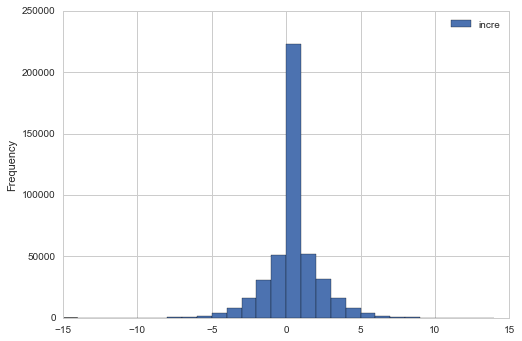

In [9]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True)

In [10]:
incre_threshold = 20 if knot_unit else 10
print 'sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )'))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

sudden increase number 6


After Simple Aretefacts Handling

In [11]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed,dir_windrose,decimal,incre,incre_reverse
date,,,,,,,,,
20070118,20070118,1250,FM-15,180,47,270,0.041049,17,0
20070118,20070118,1300,FM-12,180,47,270,0.041049,0,12
20021027,20021027,1000,FM-12,200,44,250,0.930897,10,32
19900226,19900226,700,FM-12,220,43,230,0.958975,9,18
19870327,19870327,1400,SY-MT,230,43,220,0.958975,7,3
20040320,20040320,1600,FM-12,200,43,250,0.958975,3,8
20070118,20070118,1450,FM-15,180,43,270,0.958975,8,0
20070118,20070118,1500,FM-12,180,43,270,0.958975,0,3
19900125,19900125,1650,FM-15,200,42,250,0.987052,3,0


#### 1.3.1.3 re-distribute angle, for un-evenly sectored data
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [12]:
df['dir'].value_counts().sort_index()

0       8471
10      6951
20      8510
30      8007
40      9220
50      8981
60     10744
70      9572
80     11437
90     10935
100    10442
110     8127
120     9174
130     8510
140    11190
150    10115
160    11633
170    11132
180    14326
190    13020
200    16860
210    16740
220    23871
230    22043
240    25188
250    20721
260    20177
270    14972
280    15273
290    12771
300    13760
310    11060
320    11465
330     9422
340     8789
350     7216
Name: dir, dtype: int64

In [13]:
effective_coloumn = df['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()

if len(effective_coloumn) == 16:
    # For some dataset, the angle is not evenly distributed, so there is a need to redistribute
    original_angle = list(effective_coloumn.sort_index().index)
    redistributed_angle = linspace(0,360,num=17)[:-1]
    df['dir'].replace(to_replace=original_angle, value=redistributed_angle, inplace=True)
    display(df['dir'].value_counts().sort_index())

SECTOR_LENGTH = 360/len(effective_coloumn)
print len(effective_coloumn), SECTOR_LENGTH

36 10.0


### 1.3.2 Sampling Type Selection

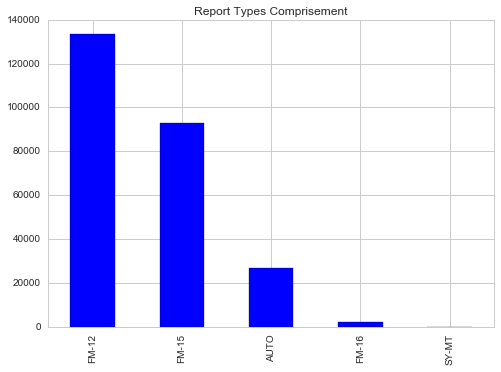

In [14]:
df.query('date > 20000000')['type'].value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement')

report_type_most_used = df.query('date > 20000000')['type'].value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.3.3 Sampling Time Selection

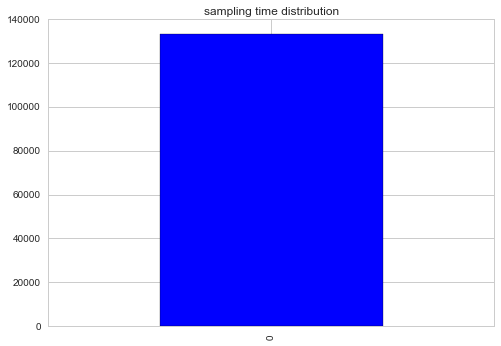

In [15]:
df['sample_time'] = df.HrMn % 100 
df.query('date > 20000000')['sample_time'].value_counts().plot(
    kind = 'bar', title = 'sampling time distribution')

sampling_time_most_used = df.query('date > 20000000')['sample_time'].value_counts().argmax()
df = df.query("sample_time==@sampling_time_most_used")
df.drop(['sample_time'], 1,inplace=True)

In [16]:
df['HrMn'].value_counts().sort_index()

0       10118
100     10342
200     10311
300     10226
400     10304
500     10267
600     10108
700     10404
800     10464
900     10376
1000    10514
1100    10548
1200    10278
1300    10575
1400    10556
1500    10434
1600    10563
1700    10608
1800    10351
1900    10638
2000    10627
2100    10504
2200    10594
2300    10473
Name: HrMn, dtype: int64

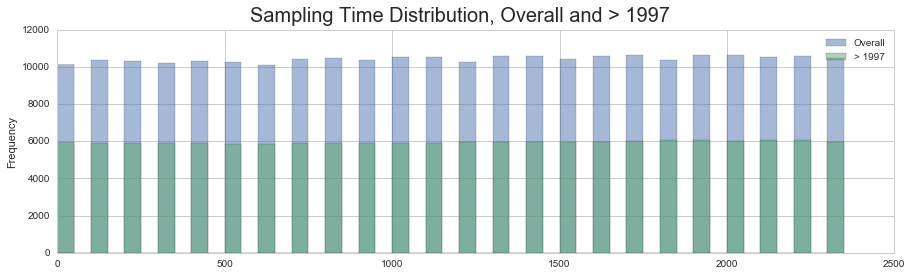

In [17]:
MID_YEAR = int(((min(df.date)+max(df.date))/2 )/10000)
# Ensure data sampled equally
bins=arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' %  MID_YEAR )

plt.suptitle('Sampling Time Distribution, Overall and > %s ' %  MID_YEAR, fontsize = 20)
plt.legend()

### 1.3.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [18]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

def randomize_angle(df, sector_length = 10):
    if DIR_REDISTRIBUTE == 'even':
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-sector_length/2,sector_length/2)))
    else:
        df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(0,sector_length)))

    bins=arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5)
    bins=arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 4))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

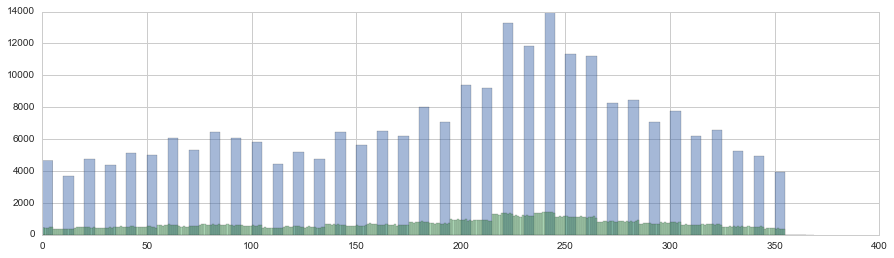

In [19]:
# Randomize the angle degree, to form a better KDE estimation
df = randomize_angle(df, SECTOR_LENGTH)

In [20]:
def randomize_speed(df):
    # Round down speed, need more caution
    df['speed_ran'] = df['speed'].apply(lambda x: (x + np.random.uniform(-1,0)) if x > 0 else x)
    
    max_speed = df.speed.max()
    df['speed'].hist(bins=arange(0, max_speed), alpha=0.5)
    df['speed_ran'].hist(bins=arange(0, max_speed, 0.5), alpha=0.5,figsize=(15, 4))
    
    df['speed']=df['speed_ran']
    df.drop(['speed_ran'], 1,inplace=True)
    return df

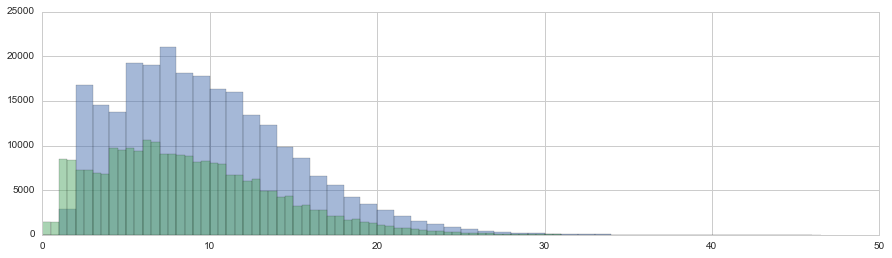

In [21]:
# Each original cell is split between the value, # so the peak is shift left
# e.g. 2 -> (1.5,2), (2,2.5); or 3 -> (2,3)
df = randomize_speed(df)

### 1.3.5 Generate (x,y) from (speed,dir)

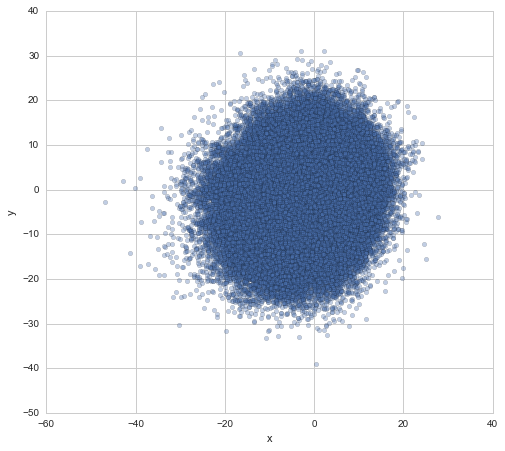

In [22]:
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)

## 1.4 Time Shift Comparison

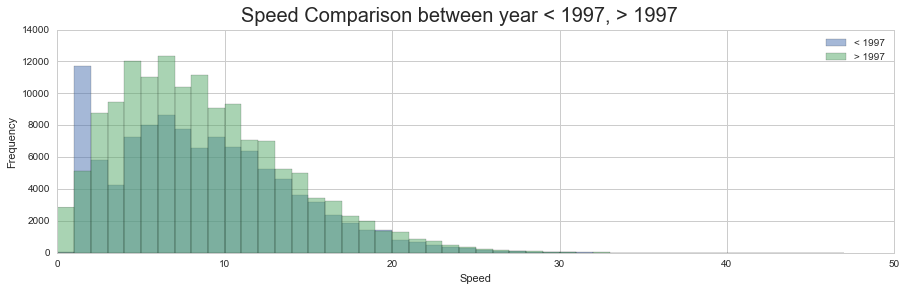

In [23]:
# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=bins, label='> %s' % MID_YEAR)

plt.xlabel("Speed")
plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.legend()

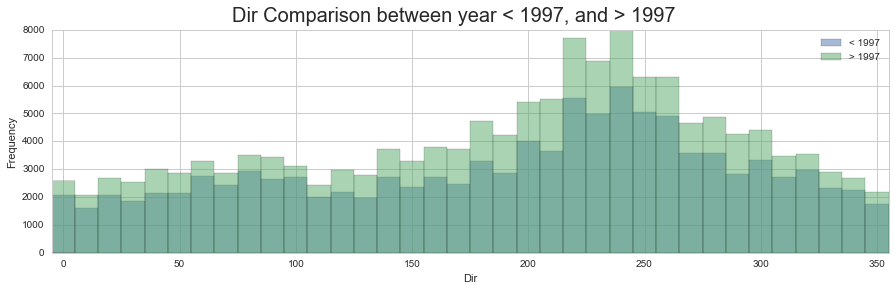

In [24]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,figsize=(15, 4),bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.xlabel("Dir")
plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 20)
plt.axis('tight')
plt.legend()

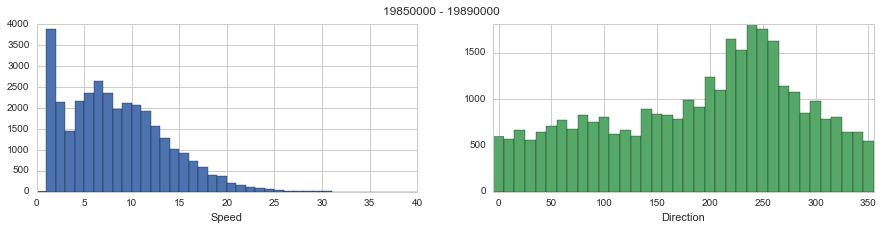

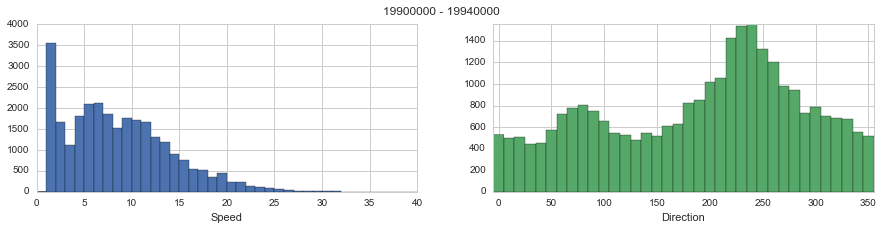

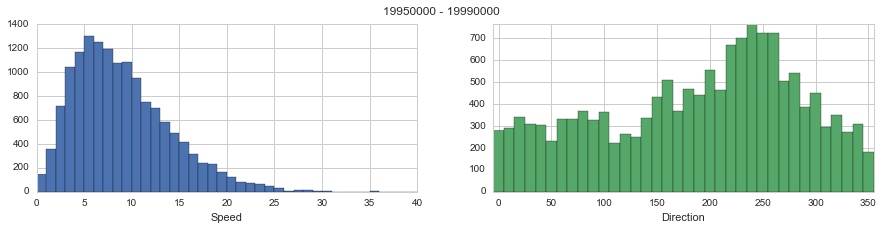

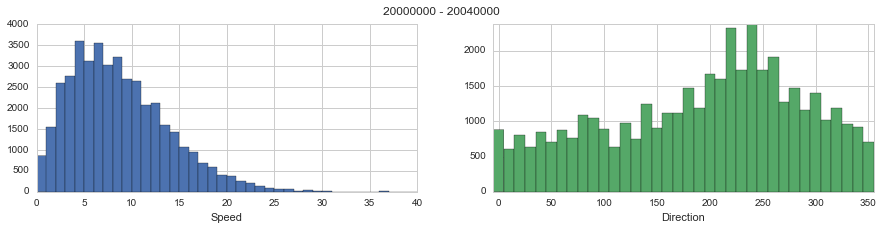

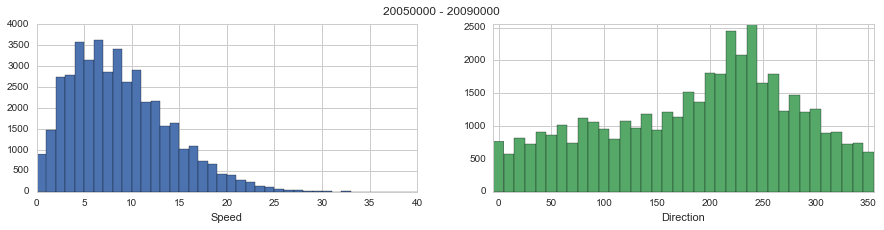

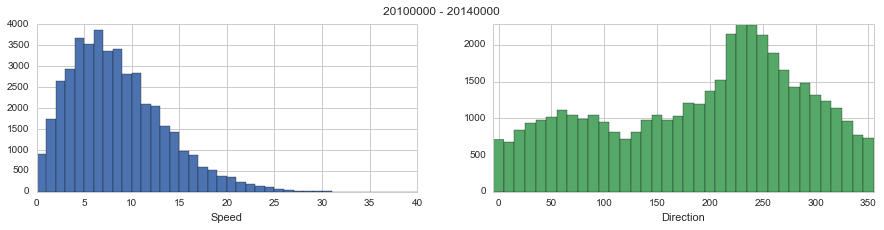

In [25]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19850000, 20150000, 50000):
        end_time = start_time + 50000 
        sub_df = df.query('(date >= @start_time) & (date < @end_time)')
        if len(sub_df) > 0 :
            title = '%s - %s' %(start_time, end_time-10000)
            plot_speed_and_angle_distribution(sub_df.speed, sub_df.dir, title)
        
check_time_shift(df)

## 1.5 Re-select data, and overview of the clean dataset

In [26]:
## Summery of the data selection
print 'incre_threshold for artefact detect:', incre_threshold
print 'Report type used:', report_type_most_used
print 'Sampling time used:', sampling_time_most_used

df_all_years = df
df = df.query('(date >= 20100000) & (date < 20150000)')
df.describe()

incre_threshold for artefact detect: 20
Report type used: FM-12
Sampling time used: 0


,date,HrMn,dir,speed,dir_windrose,decimal,incre,incre_reverse,x,y
count,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000,43407.000000
mean,20120645.524869,1151.265925,191.536189,8.474115,180.880503,0.555982,-0.000323,-0.002373,-1.648418,-1.920966
std,14137.962482,692.052220,95.118576,4.994259,93.708645,0.448161,0.162060,2.086696,6.408022,7.020301
min,20100101.000000,0.000000,-4.956846,0.000005,0.000000,0.017288,-7.000000,-18.000000,-33.010763,-33.281184
25%,20110402.000000,600.000000,111.853556,4.712050,120.000000,0.053997,0.000000,-1.000000,-5.806386,-6.432477
50%,20120629.000000,1200.000000,213.000538,7.723669,190.000000,0.913609,0.000000,0.000000,-0.931593,-1.846167
75%,20130930.000000,1800.000000,264.278619,11.397760,250.000000,0.967607,0.000000,1.000000,2.679506,2.900428
max,20141231.000000,2300.000000,354.998315,35.984409,350.000000,0.997842,7.000000,15.000000,20.032600,26.287666


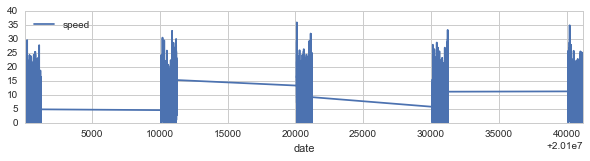

In [27]:
df['speed'].plot(legend=True,figsize=(10,2), grid=True)

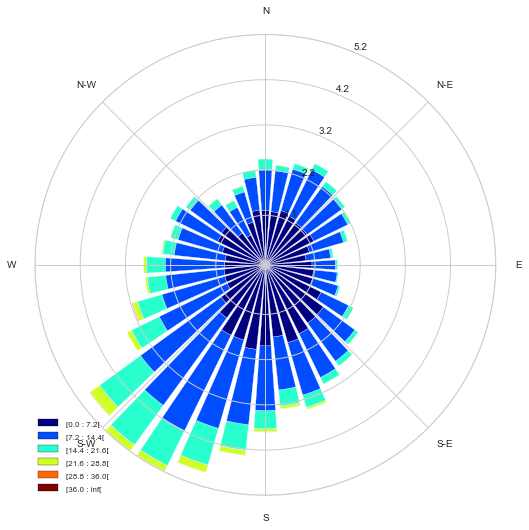

In [28]:
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

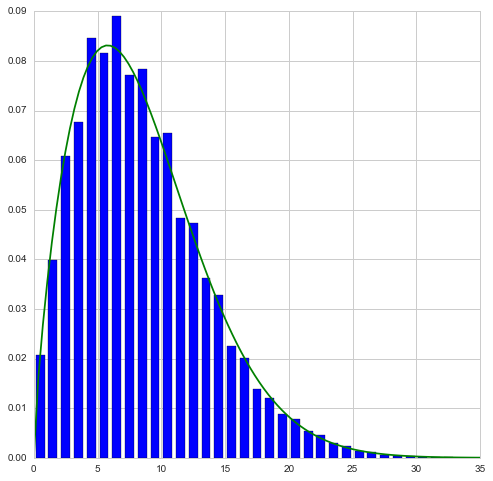

In [29]:
ax, _params = WindAxes.from_ax().pdf(df.speed, 
                                     bins=arange(0, max(df.speed)))
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)

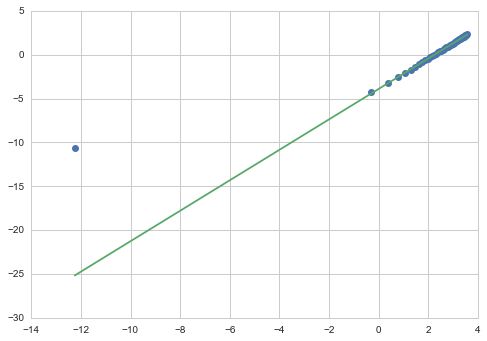

In [30]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-')

# 2. Create input data, i.e. speed_set

In [31]:
# speed_set = array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
SPEED_SET = array(zip(df.x, df.y))
max_speed = df.speed.max()
NUMBER_OF_GAUSSIAN = 3
FIT_METHOD = 'square_error'
DEFAULT_BANDWDITH = 0.9 if knot_unit else 0.4

In [32]:
FITTING_RANGE = []
if knot_unit == True:
    fitting_axis_range = arange(-20, 21, 1)
    PLOT_AXIS_RANGE = arange(-25, 25, 1)
else:
    fitting_axis_range = arange(-10, 11, 1)
    PLOT_AXIS_RANGE = arange(-10, 11, 1)
    
for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

# 3. Kernel Density Estimation

In [33]:
sample = SPEED_SET

In [34]:
# # The bandwidth value would be too radical, so we forsake this approach
# from sklearn.grid_search import GridSearchCV
# grid = GridSearchCV(neighbors.KernelDensity(),
#                     {'bandwidth': linspace(0.5, 1.0, 7)},
#                     n_jobs=-1, cv=4) 
# grid.fit(sample)
# bandwidth = grid.best_params_['bandwidth']

In [35]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH

kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print 'bandwidth:', bandwidth, len(kde_result)
print kde_result[:5]

bandwidth: 0.9 1681
[  9.35531193e-06   1.97392973e-05   3.53794209e-05   5.66070060e-05
   6.01676234e-05]


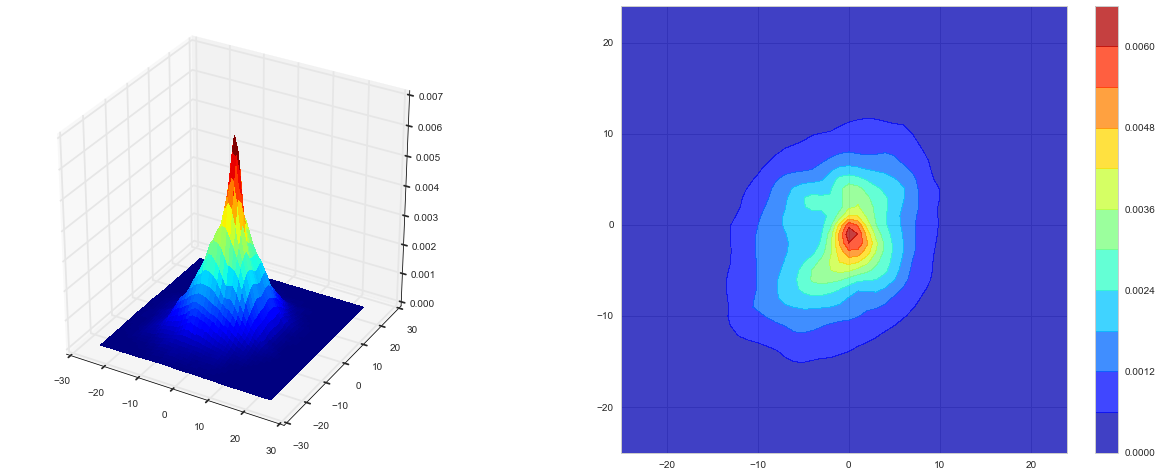

In [36]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,kde_Z,ax2)

In [37]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM Estimation, using EM algo

In [38]:
sample= SPEED_SET
clf = mixture.GMM(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print clf.converged_

True


In [39]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)  

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.373097,1.332321,-3.115597,4.768268,5.919629,0.164435
1,0.330752,-0.705399,2.782867,5.591602,5.725334,0.075661
2,0.296150,-6.456831,-5.669371,6.307535,6.715748,0.093758


GMM Plot Result
0.37309741062 [[ 1.3323206  -3.11559733]] [ 4.60239914  6.04948842] 161.48539456
0.330752485 [[-0.70539888  2.7828666 ]] [ 5.43001681  5.87880798] 143.674700974
0.29615010438 [[-6.4568311  -5.66937078]] [ 6.13711072  6.87183703] 151.897063315


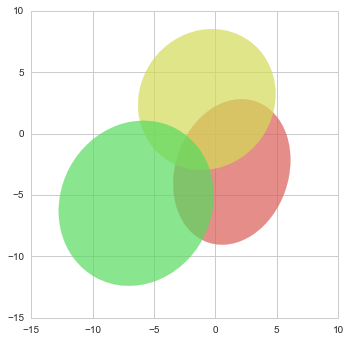

In [40]:
plot_gmm_ellipses(gmm_em_result)

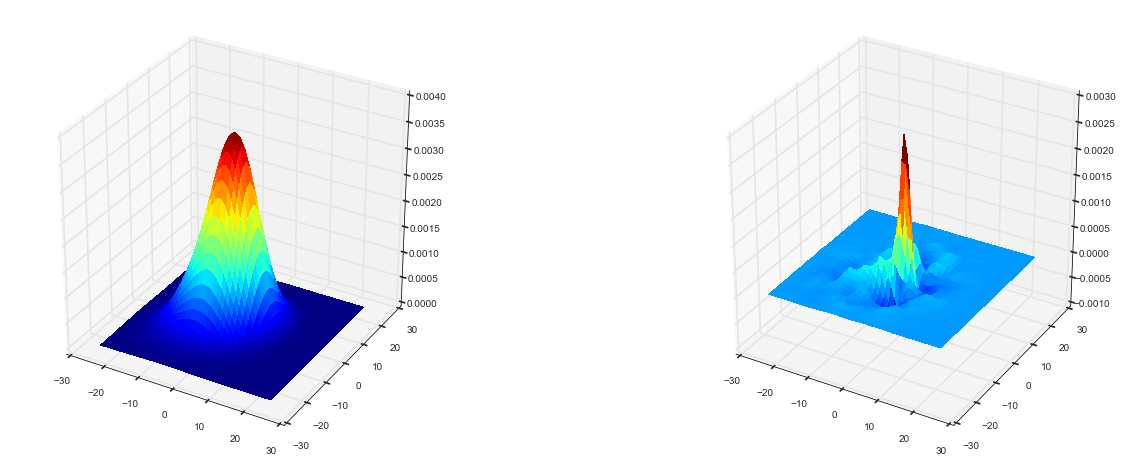

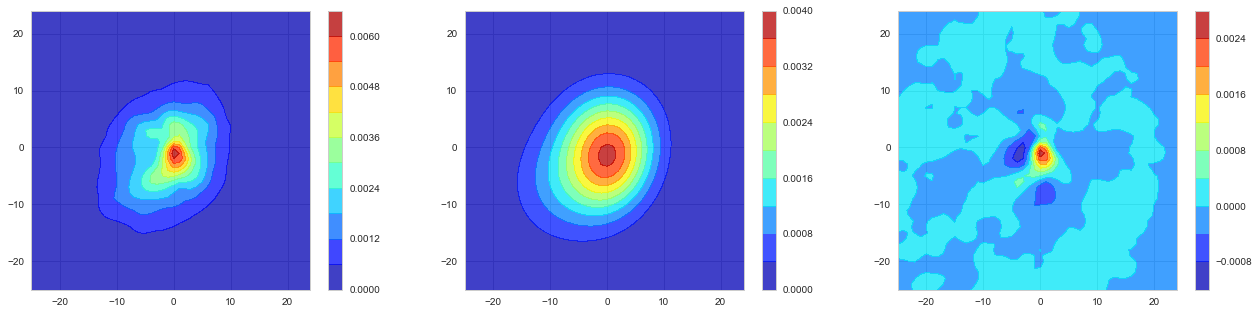

In [41]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points)[0])
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

## GMM, EM VS. KDE

In [42]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points)[0])
# put into Pandas to make it looks better
pd.DataFrame([goodness_of_fit_summary(gmm_pdf_result, kde_result)])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.039891,0.016384,4.685313e-08,0.033555,0.368323,0.943611


# 5. Least Square Prob Estimation

In [43]:
sample = SPEED_SET
points = FITTING_RANGE

In [45]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
        # {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
        # {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points,FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -18.142137358289119
     jac: array([ -2.30662346e-01,   0.00000000e+00,   2.38418579e-07,
        -2.38418579e-07,   0.00000000e+00,   0.00000000e+00,
        -2.30671167e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -2.30670691e-01,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.38418579e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 2284
     nit: 113
    njev: 113
  status: 0
 success: True
       x: array([ 0.04915982,  0.19513841, -1.93475647,  1.25085895,  2.11705539,
        0.16459054,  0.07243156,  2.5285555 , -0.99312164,  2.42912614,
        4.66631444, -0.45225054,  0.87840862, -1.74272127, -1.83413167,
        6.72920966,  7.52902701,  0.26884928])

## 5.1 GMM Result

In [46]:
kde_result[:5]

array([  9.35531193e-06,   1.97392973e-05,   3.53794209e-05,
         5.66070060e-05,   6.01676234e-05])

In [47]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)

pretty_print_gmm(gmm)

,weight,mean_x,mean_y,sig_x,sig_y,corr
0,0.878409,-1.742721,-1.834132,6.729210,7.529027,0.268849
1,0.072432,2.528555,-0.993122,2.429126,4.666314,-0.452251
2,0.049160,0.195138,-1.934756,1.250859,2.117055,0.164591


GMM Plot Result
0.878408619919 [[-1.74272127 -1.83413167]] [ 6.01812672  8.10867814] 146.357460059
0.0724315559885 [[ 2.5285555  -0.99312164]] [ 2.09501923  4.82556097] -163.571213403
0.0491598240923 [[ 0.19513841 -1.93475647]] [ 1.22512056  2.13205329] 171.681612259


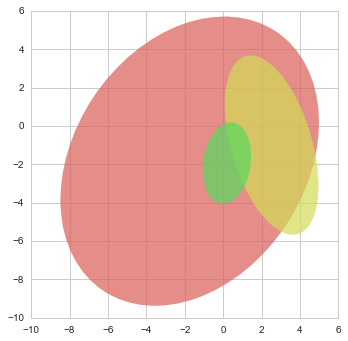

In [48]:
plot_gmm_ellipses(gmm)

## 5.2 Goodness-of-fit indicators

In [49]:
pd.DataFrame(
    [goodness_of_fit_summary(gmm_pdf_result, kde_result)])

,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.026234,0.012348,1.321204e-08,0.017819,0.195589,0.984099


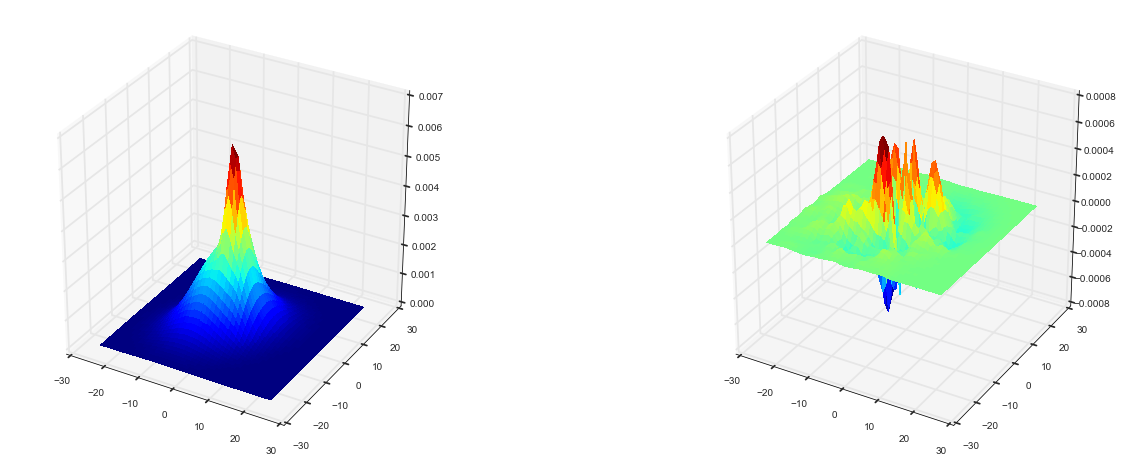

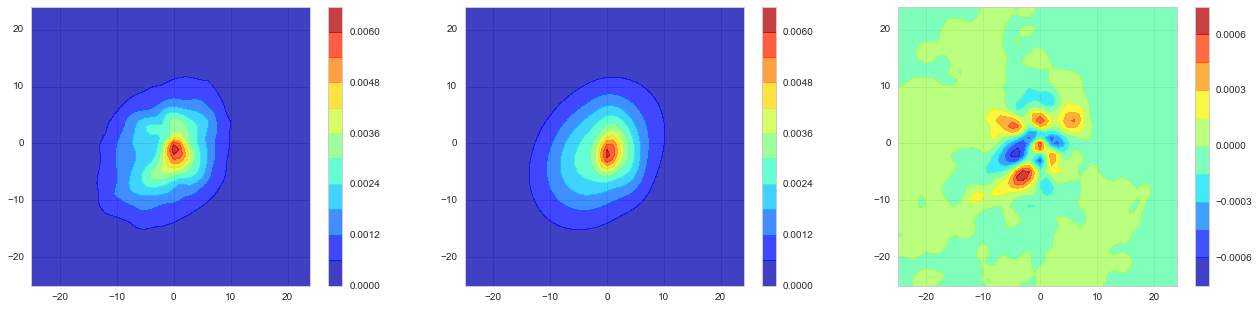

In [50]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,pdf_Z,ax1)
ax2 = fig.add_subplot(1,2,2,projection = '3d')
plot_3d_prob_density(X,Y,residual_Z,ax2)

fig = plt.figure(figsize=(22,5))
ax1 = fig.add_subplot(1,3,1)
plot_2d_prob_density(X,Y,kde_Z,ax1)
ax2 = fig.add_subplot(1,3,2)
plot_2d_prob_density(X,Y,pdf_Z,ax2)
ax3 = fig.add_subplot(1,3,3)
plot_2d_prob_density(X,Y,residual_Z,ax3)

In [51]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = arange(0, max_speed)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x_vals_OEN3_LMSE ]

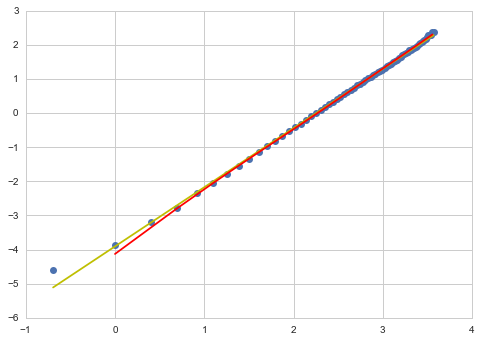

In [52]:
x = arange(0, max_speed, 0.5)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plt.plot(log(x), log(-log(1-y)),'o')

# 2. Weibull distribution
w_scale, c_shape = weibull_params[1], weibull_params[3]
qz=exp(-(x/c_shape)**w_scale)
plt.plot(log(x), log(-log(qz)),'-', color = 'y')

# 3. OEN3 distribution
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = array(zip(*y_)[0])
plt.plot(log(x), log(-log(1-y)),'-', color = 'r')

plt.show()

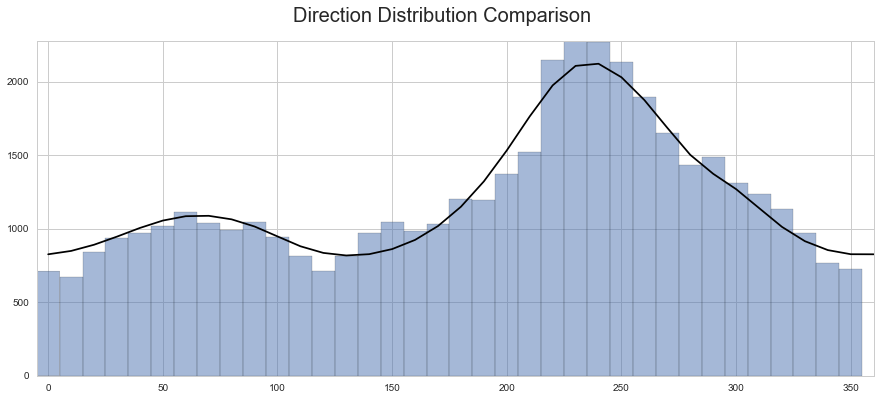

In [53]:
# Calculate Angle Distribution
x_vals = linspace(0,2*pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-pi/36, x_val+pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = array(zip(*y_vals_)[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.axis('tight')
plt.show()

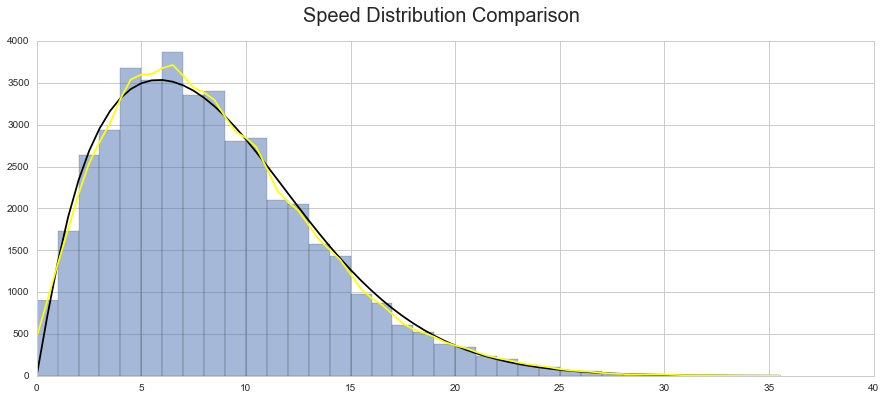

In [54]:
# Calculate Speed Distribution
# 1. GMM Model
x_vals = arange(0, max_speed, 0.5)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[0, 2*pi]]) for x_val in x_vals]
y_vals = array(zip(*y_vals_)[0])*len(df.speed)/0.2
plt.plot(x_vals, y_vals,'-', color='black')

# 2. Observation
df['speed'].hist(bins=arange(0, max_speed), alpha=0.5,figsize=(15, 6))

# 3. 1d KDE
sample = array(df.speed).reshape(-1, 1)
kde_temp = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(kde_temp.score_samples(x_val))*len(sample) for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

## 5.3 Angle-wise Comaprison

In [55]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_histogram(df.speed, 360/incre)
    hist_y_axis = [0, max_speed, 0, max_count]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        
        # 1. Count Comparison
        # 1.1. Data Histogram
        fig = plt.figure(figsize=(22,4))
        ax1 = fig.add_subplot(1,4,1)        
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5)
        plt.axis(hist_y_axis)
        
        # 1.2. Model Distribution
        x_vals = arange(0, sub_max_speed, 0.2)
        y_vals_ =[integrate.nquad(f, 
                  [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                  for x_val in x_vals]
        y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2
        plt.plot(x_vals, y_vals,'-', color='black')
        
        # 2. CDF Comaprison
        x =arange(0, sub_max_speed, 0.5)
        # 2.1. Data's empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_cdf = ecdf(x)
        
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_gmm = array(zip(*y_)[0])/direction_prob[0]
                
        # 2.3.1. Plot in ordinary axis
        ax3 = fig.add_subplot(1,4,2)
        plt.plot(x, y_cdf,'o')
        plt.plot(x, y_gmm,'-', color = 'r')
        
        # 2.3.2. P-P Plot
        ax2 = fig.add_subplot(1,4,3)
        p_line = linspace(0, 1)
        plt.plot(y_gmm,y_cdf, 'o')
        plt.plot(p_line, p_line,'-')
        
        # 2.3.3. Weibull plot
        ax4 = fig.add_subplot(1,4,4)
        plt.plot(log(x), log(-log(1-y_cdf)),'o')
        plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'r')
        
        plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
                     fontsize = 15)
        plt.show()
        
        diff = abs(y_cdf - y_gmm)
        max_diff_array.append([angle, diff.max(), x[diff.argmax()]])
        print 'max diff:', diff.max(), ', speed value:', x[diff.argmax()], 'y gmm', y_gmm[diff.argmax()],
    return max_diff_array

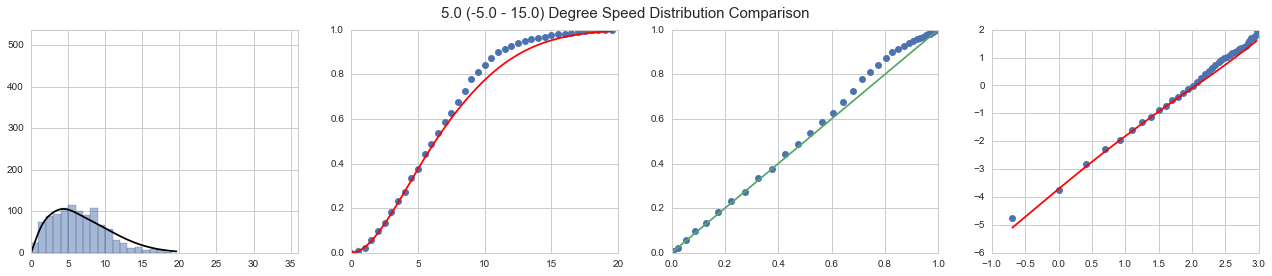

max diff: 0.0707079287781 , speed value: 11.0 y gmm 0.826876612285

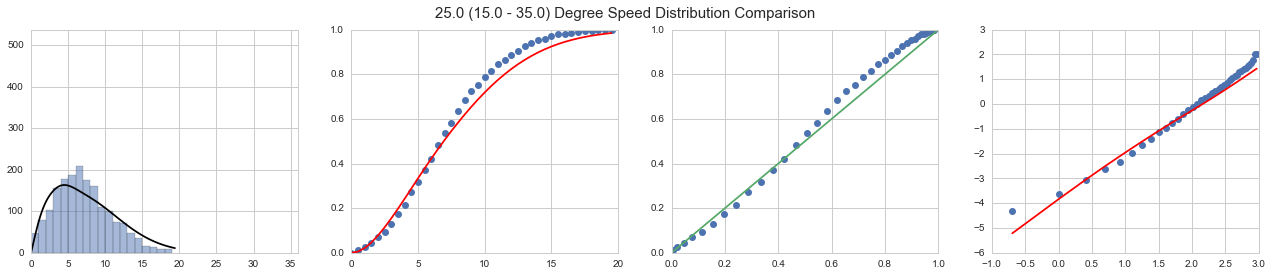

 max diff: 0.0718671989269 , speed value: 9.0 y gmm 0.654590200176

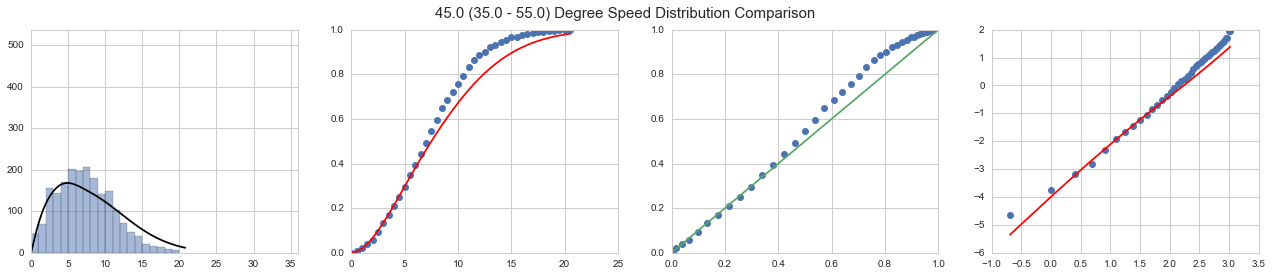

 max diff: 0.104953083437 , speed value: 11.5 y gmm 0.756855961789

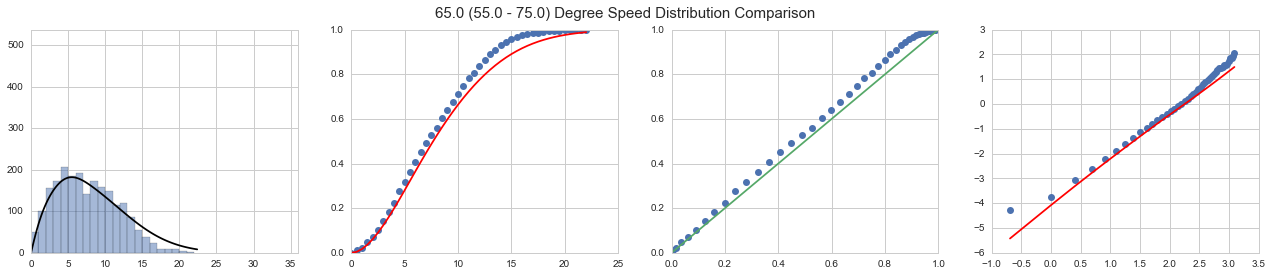

 max diff: 0.0728822295292 , speed value: 14.0 y gmm 0.858440276271

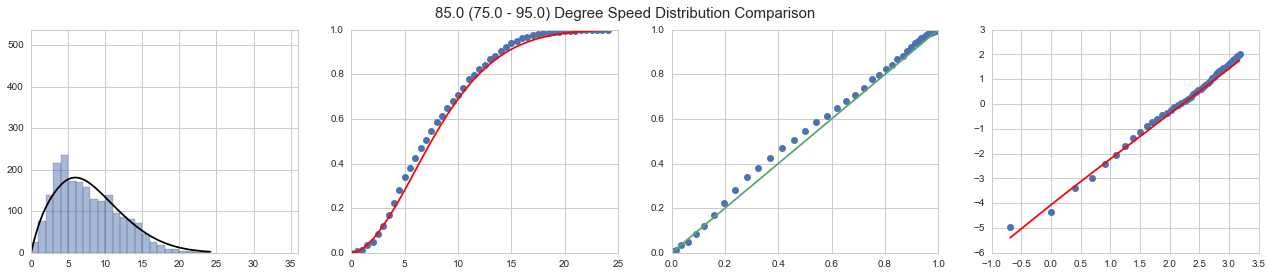

 max diff: 0.0575992269515 , speed value: 5.0 y gmm 0.280960302691

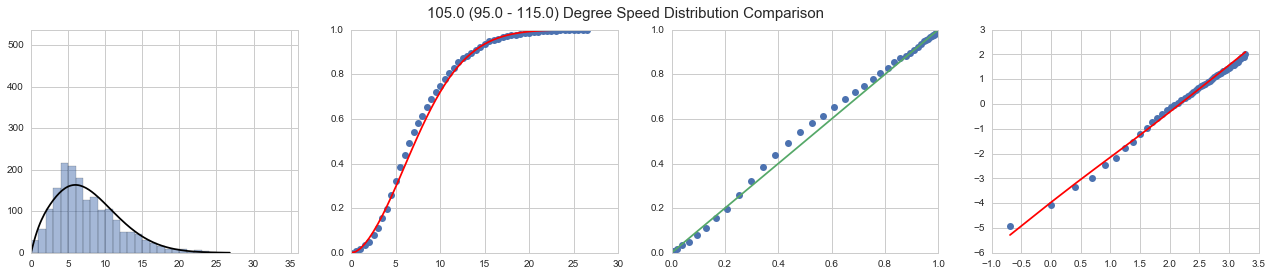

 max diff: 0.0599462185452 , speed value: 7.0 y gmm 0.480394690546

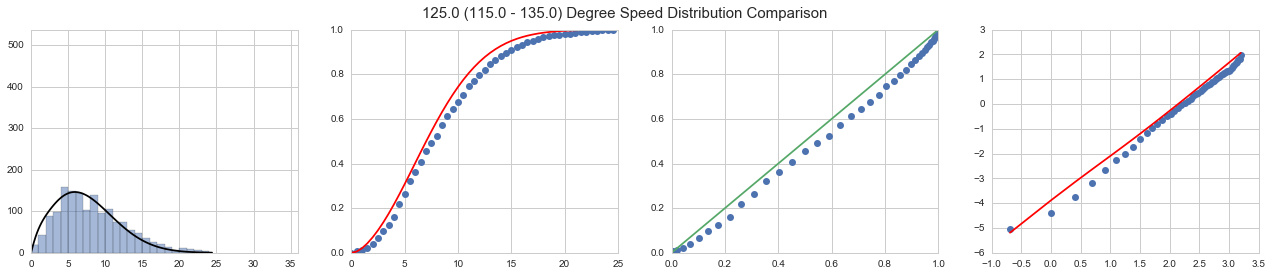

 max diff: 0.0690756225311 , speed value: 10.5 y gmm 0.77568989889

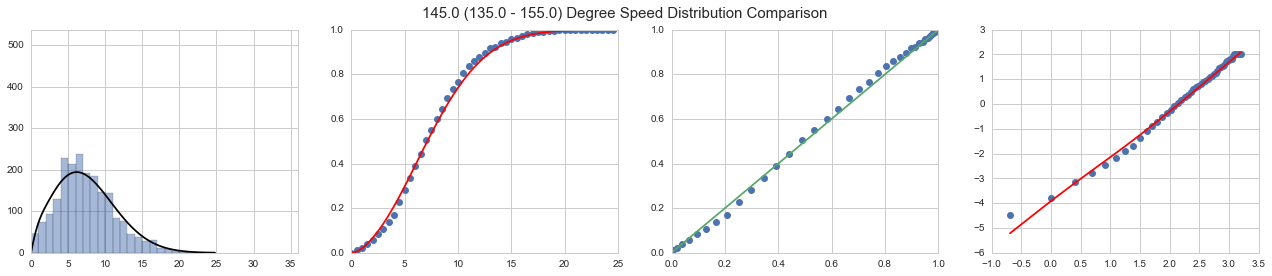

 max diff: 0.0394340059831 , speed value: 4.0 y gmm 0.208824793502

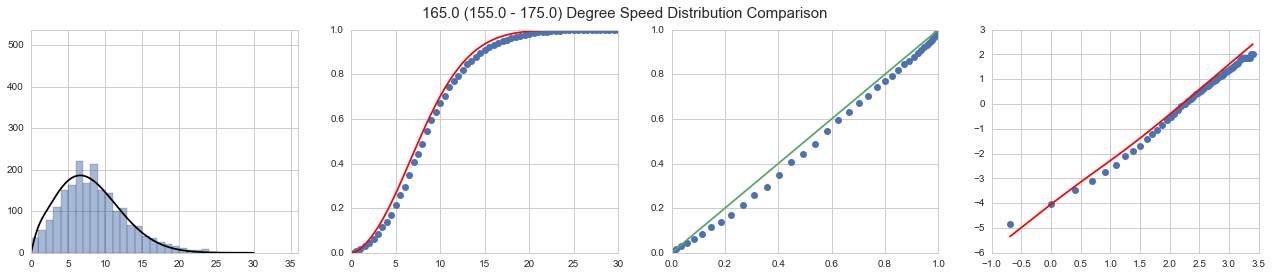

 max diff: 0.060578075004 , speed value: 6.0 y gmm 0.356010051171

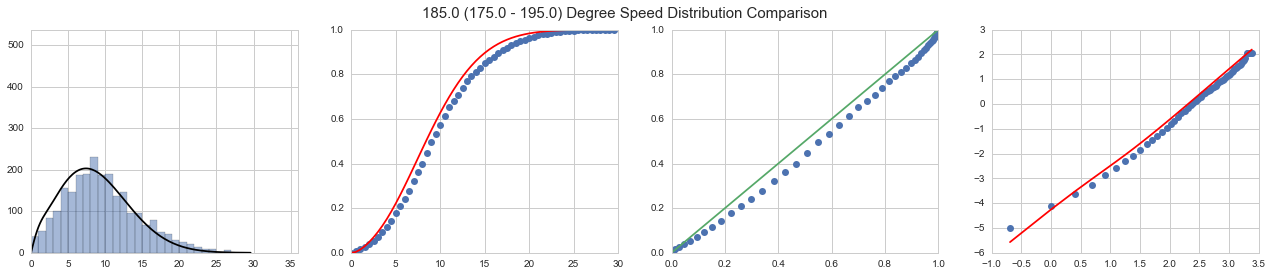

 max diff: 0.0685219755413 , speed value: 8.0 y gmm 0.467021350281

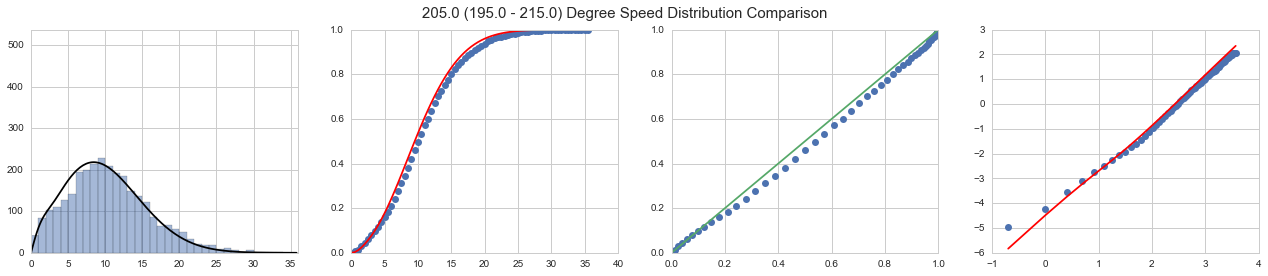

 max diff: 0.044977929643 , speed value: 8.5 y gmm 0.425074681543

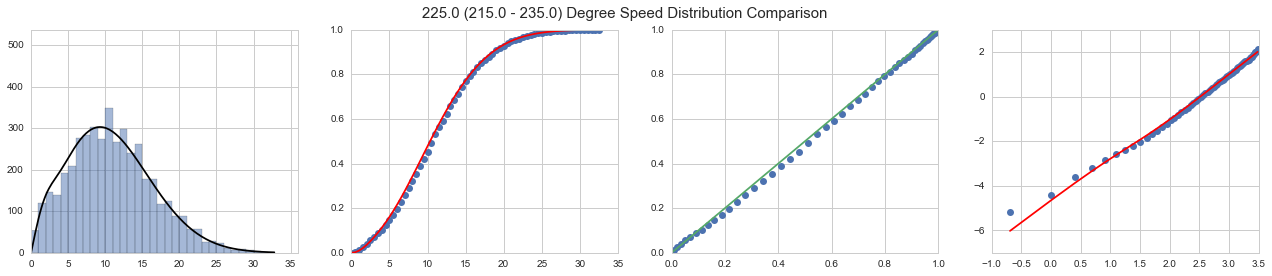

 max diff: 0.0263111091479 , speed value: 10.0 y gmm 0.477814613557

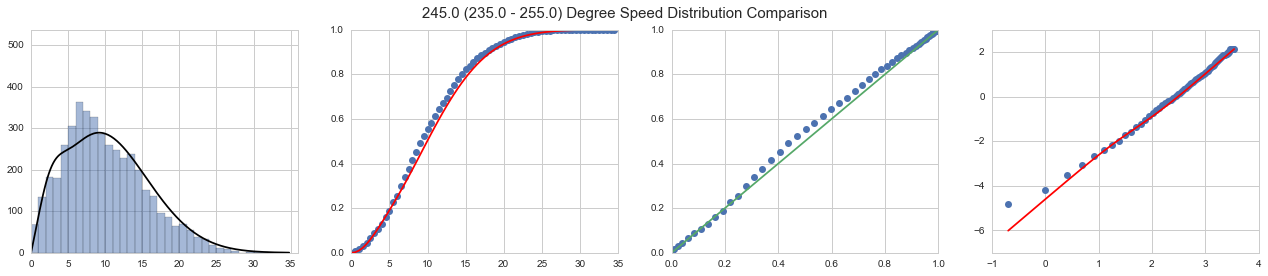

 max diff: 0.0529702229851 , speed value: 9.0 y gmm 0.437617211807

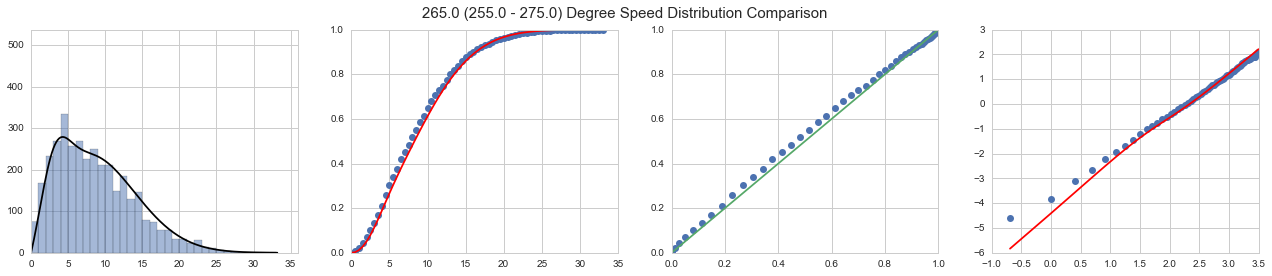

 max diff: 0.0420404822284 , speed value: 6.5 y gmm 0.377468962373

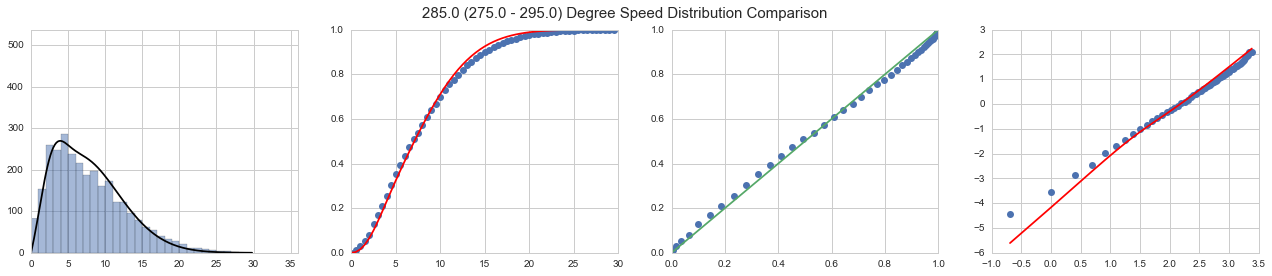

 max diff: 0.0291444617388 , speed value: 5.0 y gmm 0.324079132226

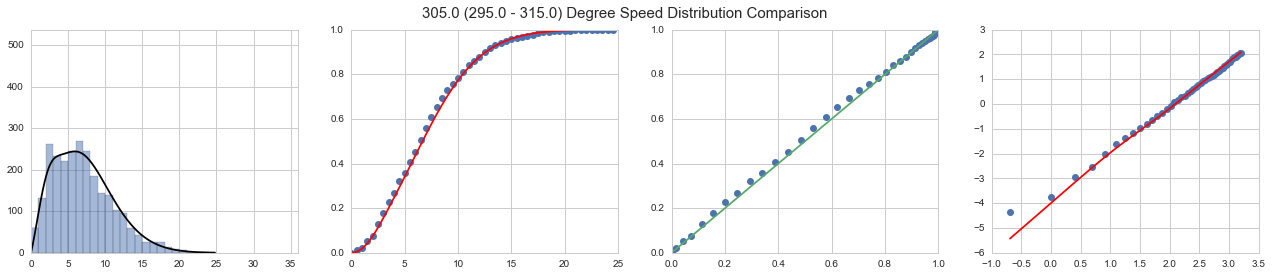

 max diff: 0.0337006427121 , speed value: 8.0 y gmm 0.621187460939

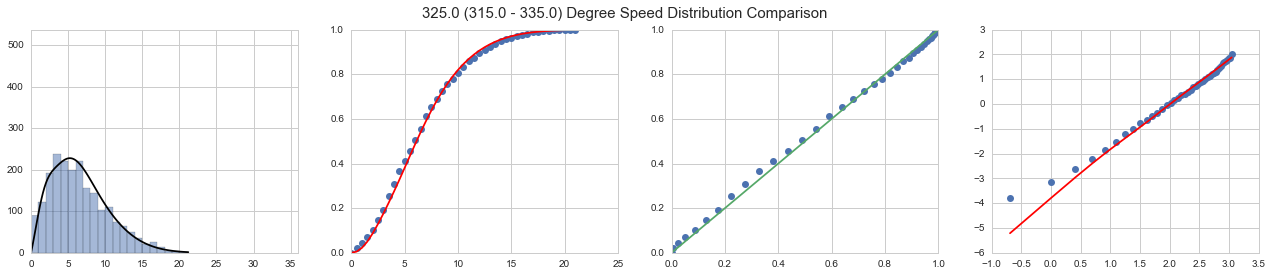

 max diff: 0.0390234486582 , speed value: 4.5 y gmm 0.32729434392

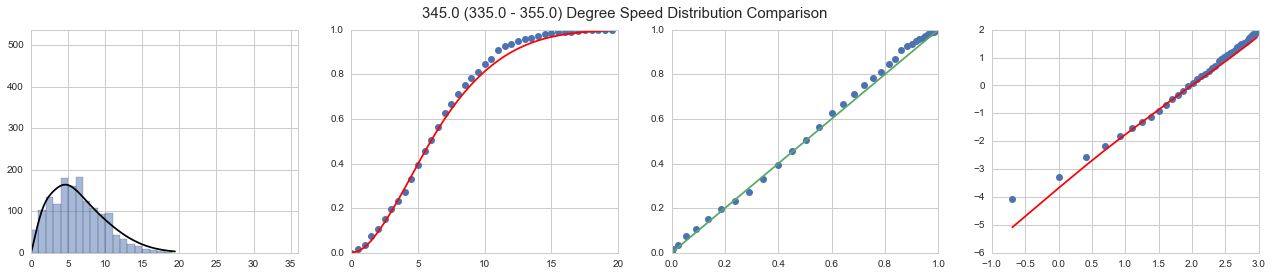

 max diff: 0.0472279828993 , speed value: 11.0 y gmm 0.861071883232


In [56]:
if len(effective_coloumn) == 16:
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 22.5)
else: 
    max_diff_array = model_data_comparison(df, SECTOR_LENGTH, 20)

### 5.3.1 Variance over the years

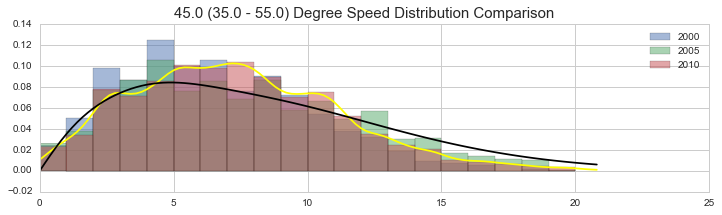

In [57]:
max_diff_element = max(max_diff_array, key=lambda x: x[1])
angle =  max_diff_angle = max_diff_element[0]
incre = 20

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, max_speed = select_df_by_angle(df, start_angle, end_angle)

x_vals = arange(0, max_speed, 0.2)

# 1. 1d KDE 
sample = array(sub_df.speed).reshape(-1, 1)
sub_kde = neighbors.KernelDensity(bandwidth=0.5).fit(sample) 
y_vals = [exp(sub_kde.score_samples(x_val))
          for x_val in x_vals]
plt.plot(x_vals, y_vals,'-', color='yellow')

# 2. GMM
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] /0.2
plt.plot(x_vals, y_vals,'-', color='black')

for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years) > 0 :
        df_other_years_at_angle['speed'].hist(bins=arange(0, max_speed), normed=True,
                                              alpha=0.5,figsize=(12, 3), 
                                              label = str(int(start_time/10000)))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)
plt.legend()
plt.show()

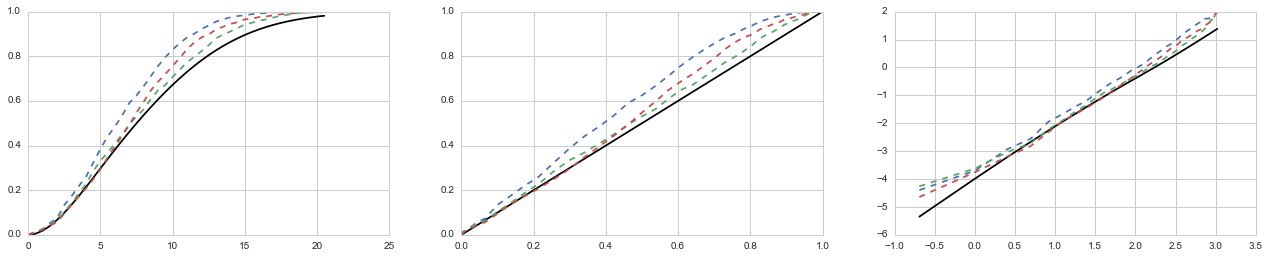

In [58]:
fig = plt.figure(figsize=(22,4))

x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,3,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax2 = fig.add_subplot(1,3,2) 
p_line = linspace(0, 1)
plt.plot(p_line, p_line,'-',color = 'black')

ax3 = fig.add_subplot(1,3,3) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, _ = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years) > 0 :
        
        sample = df_other_years_at_angle.speed
        ecdf = sm.distributions.ECDF(sample)
        y_cdf = ecdf(x)

        ax1 = fig.add_subplot(1,3,1) 
        plt.plot(x, y_cdf,'--')

        ax2 = fig.add_subplot(1,3,2) 
        plt.plot(y_gmm, y_cdf, '--')

        ax3 = fig.add_subplot(1,3,3) 
        plt.plot(log(x), log(-log(1-y_cdf)),'--')

### 5.3.2 Bootstrap, to see the variance of each sector

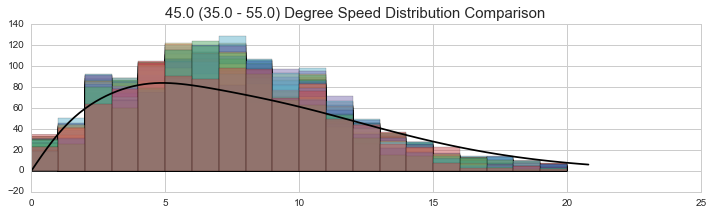

In [59]:
FRACTION = 0.5 

x_vals = arange(0, max_speed, 0.2)
y_vals_ =[integrate.nquad(f, [[x_val-0.1, x_val+0.1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_val in x_vals]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_vals = array(zip(*y_vals_)[0])/direction_prob[0] * len(sub_df.speed)/0.2 * FRACTION
plt.plot(x_vals, y_vals,'-', color='black')

bins = arange(0, max_speed, 1)
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    sub_df_resampled['speed'].hist(bins=bins, alpha=0.5,figsize=(12, 3))

plt.suptitle('%s (%s - %s) Degree Speed Distribution Comparison' % (angle, start_angle, end_angle), 
             fontsize = 15)

0.0921984650144 13.0 0.82639449981


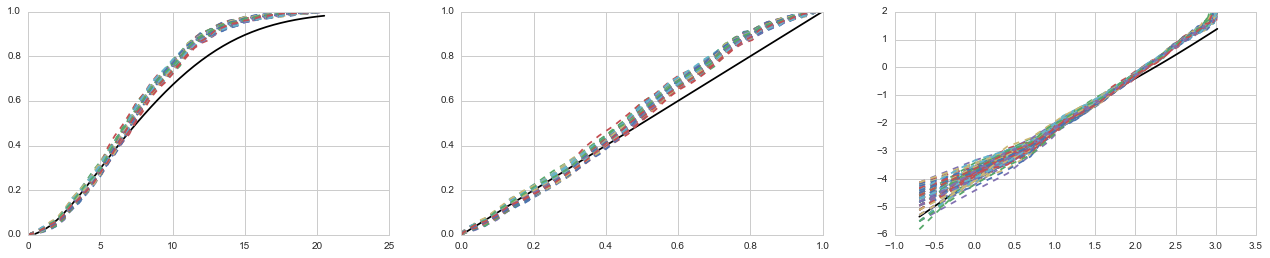

In [60]:
fig = plt.figure(figsize=(22,4))

x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
direction_prob = integrate.nquad(f, [[0, inf],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_)[0])/direction_prob[0]

ax1 = fig.add_subplot(1,3,1) 
plt.plot(x, y_gmm,'-', color = 'black')

ax2 = fig.add_subplot(1,3,2) 
p_line = linspace(0, 1)
plt.plot(p_line, p_line,'-',color = 'black')

ax3 = fig.add_subplot(1,3,3) 
plt.plot(log(x), log(-log(1-y_gmm)),'-', color = 'black')

for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)
    
    sample = sub_df_resampled.speed
    ecdf = sm.distributions.ECDF(sample)
    y_cdf = ecdf(x)

    ax1 = fig.add_subplot(1,3,1) 
    plt.plot(x, y_cdf,'--')

    ax2 = fig.add_subplot(1,3,2) 
    plt.plot(y_gmm, y_cdf, '--')

    ax3 = fig.add_subplot(1,3,3) 
    plt.plot(log(x), log(-log(1-y_cdf)),'--')
    
diff = abs(y_cdf - y_gmm)
print diff.max(), x[diff.argmax()], y_gmm[diff.argmax()]

# 6. Variance of results & Cross Validation

In [61]:
from sklearn.cross_validation import train_test_split, KFold
    
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
    
points = FITTING_RANGE
    
def fit_gmm(df, number_of_gaussian = 3, fit_method = 'square_error'):
    # 1. Create Input, speed_set
    sample = sub_speed_set = array(zip(df.x, df.y))
    points = FITTING_RANGE
    
    # 2. KDE + EM fitting
    kde = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result = exp(kde.score_samples(points))
    
    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    gmm_em_result = read_gmm_em_result(clf)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
    cons = [{'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},]
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result, points, method=fit_method),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)       
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_clf': kde,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit}

## 6.1 Variance of the Result

In [62]:
# for i in range(10):
#     df_resampled = df.sample(frac=1, replace=True)
#     result = fit_gmm(df_resampled, NUMBER_OF_GAUSSIAN, fit_method = FIT_METHOD)
#     plot_gmm_ellipses(result['gmm'])
#     display(pd.DataFrame(
#         [goodness_of_fit_summary(result['gmm_pdf_result'], result['kde_result'])]))

## 6.2 Cross validation, to select the number of Gaussian

In [63]:
## 5-fold cross validation
gaussian_number_range = arange(1,6)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) # each number of gaussian, fit 4 times

    CV_result_train, CV_result_test = [],[]
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']
        kde_result_train = result['kde_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_train,)
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test,)
        
        display(pd.DataFrame([gof_train, gof_test], index=["gof_train", "gof_test"]))
        
        CV_result_train.append(gof_train)
        CV_result_test.append(gof_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)

Number of train/test dataset 32555.25 10851.75
  
Number of gaussian 1


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.059778,0.046636,7.059801e-08,0.041062,0.452254,0.914877
gof_test,0.070408,0.046874,7.852469e-08,0.043848,0.476411,0.906620


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.058971,0.046713,7.075887e-08,0.041157,0.452698,0.915512
gof_test,0.074772,0.045012,7.314704e-08,0.042171,0.460024,0.910495


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.058392,0.046773,7.125184e-08,0.040890,0.454249,0.914141
gof_test,0.072481,0.050486,7.602482e-08,0.044335,0.469059,0.909442


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.059973,0.047233,7.169309e-08,0.042225,0.455382,0.913487
gof_test,0.068522,0.046425,7.208201e-08,0.039601,0.457552,0.914451


  
Number of gaussian 2


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.027213,0.011985,2.824303e-08,0.025701,0.285992,0.966315
gof_test,0.032064,0.010773,2.661543e-08,0.026371,0.277530,0.967242


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.024762,0.009638,2.567359e-08,0.025331,0.272655,0.968660
gof_test,0.040467,0.012052,3.933319e-08,0.029052,0.337449,0.954864


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.026667,0.008820,2.818730e-08,0.025788,0.285619,0.966518
gof_test,0.033879,0.015673,2.978347e-08,0.027518,0.293862,0.962880


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.026158,0.009970,2.921309e-08,0.026589,0.290869,0.964615
gof_test,0.034869,0.013658,2.944389e-08,0.026324,0.291883,0.965391


  
Number of gaussian 3


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.018176,0.008906,1.346812e-08,0.017996,0.197404,0.983826
gof_test,0.027849,0.016080,1.937050e-08,0.021556,0.237082,0.976656


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.017961,0.009549,1.414753e-08,0.018570,0.202366,0.982893
gof_test,0.028742,0.019836,1.943778e-08,0.021164,0.237341,0.977075


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.018140,0.009725,1.454755e-08,0.018726,0.205287,0.982450
gof_test,0.027955,0.010132,1.712593e-08,0.020197,0.222518,0.979663


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.018211,0.010443,1.499468e-08,0.018816,0.208420,0.982080
gof_test,0.029093,0.017249,1.811736e-08,0.021436,0.228861,0.977903


  
Number of gaussian 4


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.016016,0.009546,1.391815e-08,0.018667,0.200790,0.983192
gof_test,0.026355,0.012414,1.848429e-08,0.019869,0.231198,0.978107


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.016467,0.010090,1.425002e-08,0.018130,0.203147,0.982912
gof_test,0.024707,0.015102,1.692930e-08,0.021505,0.221333,0.979532


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.015356,0.008014,1.319338e-08,0.017700,0.195388,0.984079
gof_test,0.027222,0.013156,1.857891e-08,0.021518,0.232160,0.977930


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.016230,0.009443,1.372030e-08,0.018276,0.199317,0.983559
gof_test,0.025021,0.012837,1.815109e-08,0.020488,0.229246,0.977995


  
Number of gaussian 5


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.011907,0.008672,8.284242e-09,0.014000,0.154861,0.990070
gof_test,0.024627,0.013258,1.760479e-08,0.021063,0.225843,0.978699


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.012163,0.006745,8.418710e-09,0.014336,0.156146,0.989925
gof_test,0.023282,0.012701,1.024724e-08,0.015334,0.172194,0.987531


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.010372,0.003200,4.676703e-09,0.010487,0.116426,0.994367
gof_test,0.020284,0.012838,1.068401e-08,0.016564,0.175615,0.987259


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
gof_train,0.009997,0.004027,5.156278e-09,0.011254,0.122124,0.993752
gof_test,0.021907,0.009930,9.181395e-09,0.014384,0.163302,0.989236


In [64]:
for idx in gaussian_number_range:
    print 'number of gaussian', idx
    print 'Train'
    display(pd.DataFrame(CV_result_train_all[idx-1]))
    print 'Test'
    display(pd.DataFrame(CV_result_test_all[idx-1]))

number of gaussian 1
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.059778,0.046636,7.059801e-08,0.041062,0.452254,0.914877
1,0.058971,0.046713,7.075887e-08,0.041157,0.452698,0.915512
2,0.058392,0.046773,7.125184e-08,0.040890,0.454249,0.914141
3,0.059973,0.047233,7.169309e-08,0.042225,0.455382,0.913487


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.070408,0.046874,7.852469e-08,0.043848,0.476411,0.906620
1,0.074772,0.045012,7.314704e-08,0.042171,0.460024,0.910495
2,0.072481,0.050486,7.602482e-08,0.044335,0.469059,0.909442
3,0.068522,0.046425,7.208201e-08,0.039601,0.457552,0.914451


number of gaussian 2
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.027213,0.011985,2.824303e-08,0.025701,0.285992,0.966315
1,0.024762,0.009638,2.567359e-08,0.025331,0.272655,0.968660
2,0.026667,0.008820,2.818730e-08,0.025788,0.285619,0.966518
3,0.026158,0.009970,2.921309e-08,0.026589,0.290869,0.964615


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.032064,0.010773,2.661543e-08,0.026371,0.277530,0.967242
1,0.040467,0.012052,3.933319e-08,0.029052,0.337449,0.954864
2,0.033879,0.015673,2.978347e-08,0.027518,0.293862,0.962880
3,0.034869,0.013658,2.944389e-08,0.026324,0.291883,0.965391


number of gaussian 3
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.018176,0.008906,1.346812e-08,0.017996,0.197404,0.983826
1,0.017961,0.009549,1.414753e-08,0.018570,0.202366,0.982893
2,0.018140,0.009725,1.454755e-08,0.018726,0.205287,0.982450
3,0.018211,0.010443,1.499468e-08,0.018816,0.208420,0.982080


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.027849,0.016080,1.937050e-08,0.021556,0.237082,0.976656
1,0.028742,0.019836,1.943778e-08,0.021164,0.237341,0.977075
2,0.027955,0.010132,1.712593e-08,0.020197,0.222518,0.979663
3,0.029093,0.017249,1.811736e-08,0.021436,0.228861,0.977903


number of gaussian 4
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.016016,0.009546,1.391815e-08,0.018667,0.200790,0.983192
1,0.016467,0.010090,1.425002e-08,0.018130,0.203147,0.982912
2,0.015356,0.008014,1.319338e-08,0.017700,0.195388,0.984079
3,0.016230,0.009443,1.372030e-08,0.018276,0.199317,0.983559


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.026355,0.012414,1.848429e-08,0.019869,0.231198,0.978107
1,0.024707,0.015102,1.692930e-08,0.021505,0.221333,0.979532
2,0.027222,0.013156,1.857891e-08,0.021518,0.232160,0.977930
3,0.025021,0.012837,1.815109e-08,0.020488,0.229246,0.977995


number of gaussian 5
Train


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.011907,0.008672,8.284242e-09,0.014000,0.154861,0.990070
1,0.012163,0.006745,8.418710e-09,0.014336,0.156146,0.989925
2,0.010372,0.003200,4.676703e-09,0.010487,0.116426,0.994367
3,0.009997,0.004027,5.156278e-09,0.011254,0.122124,0.993752


Test


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.024627,0.013258,1.760479e-08,0.021063,0.225843,0.978699
1,0.023282,0.012701,1.024724e-08,0.015334,0.172194,0.987531
2,0.020284,0.012838,1.068401e-08,0.016564,0.175615,0.987259
3,0.021907,0.009930,9.181395e-09,0.014384,0.163302,0.989236


In [65]:
mean_gof_train_all = generate_mean_gof(CV_result_train_all)
print 'Train mean gof'
display(mean_gof_train_all)

mean_gof_test_all = generate_mean_gof(CV_result_test_all)
print 'Test mean gof'
display(mean_gof_test_all)

Train mean gof


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.059278,0.046839,7.107545e-08,0.041334,0.453646,0.914504
1,0.026200,0.010103,2.782925e-08,0.025852,0.283784,0.966527
2,0.018122,0.009656,1.428947e-08,0.018527,0.203369,0.982812
3,0.016017,0.009273,1.377046e-08,0.018193,0.199661,0.983436
4,0.011110,0.005661,6.633983e-09,0.012519,0.137389,0.992028


Test mean gof


,Chi_square,K_S,MSE,RMSE / Max,RMSE / Mean,R_square
0,0.071545,0.047199,7.494464e-08,0.042489,0.465762,0.910252
1,0.035320,0.013039,3.129400e-08,0.027316,0.300181,0.962594
2,0.028410,0.015824,1.851289e-08,0.021088,0.231450,0.977824
3,0.025826,0.013377,1.803590e-08,0.020845,0.228484,0.978391
4,0.022525,0.012181,1.192936e-08,0.016836,0.184239,0.985681


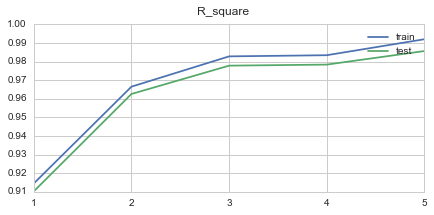

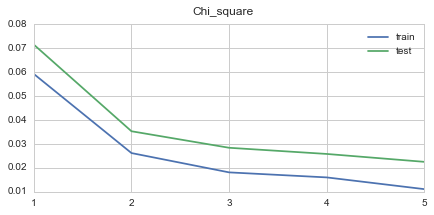

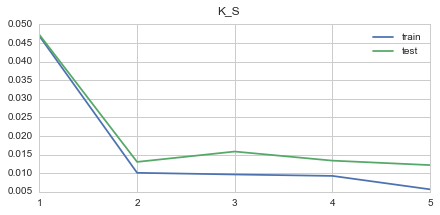

In [66]:
for column in ['R_square','Chi_square', 'K_S']:
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 3)
    plt.plot(gaussian_number_range, mean_gof_train_all[column],'-', label = 'train')
    plt.plot(gaussian_number_range, mean_gof_test_all[column],'-', label = 'test')
    plt.suptitle(column)
    plt.xticks(gaussian_number_range)
    plt.legend()
    plt.show()

## 6.3 Variance of KDE

In [67]:
sss

NameError: name 'sss' is not defined

In [ ]:
## 5-fold cross validation
gaussian_number_range = arange(3,5)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) # each number of gaussian, fit 4 times

    CV_result_train, CV_result_test = [],[]
    for train_index, test_index in kf:
        sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, fit_method = FIT_METHOD)
        gmm_pdf_result_train = result['gmm_pdf_result']
        kde_train = result['kde_clf']
        kde_result_train = result['kde_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
        kde_result_test = exp(kde_test.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_train,)
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test,)
                
        # Plot jPDF
        X = Y = PLOT_AXIS_RANGE
        kde_train_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde_train.score_samples(coords)))
        fig = plt.figure(figsize=(22,6))
        ax1 = fig.add_subplot(1,3,1)
        plot_2d_prob_density(X,Y,kde_train_Z, ax1)
        
        ax2 = fig.add_subplot(1,3,2)
        kde_test_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde_test.score_samples(coords)))
        plot_2d_prob_density(X,Y,kde_test_Z, ax2)
            
        ax3 = fig.add_subplot(1,3,3)
        plot_2d_prob_density(X,Y,kde_train_Z-kde_test_Z,ax3)
        
        display(pd.DataFrame([gof_train, gof_test], index=["gof_train", "gof_test"]))
        